In [3]:
# Generate visible points on a sphere from a viewpoing
# Bare-bones implementation, lightly commented
# Andrew Glassner, June 2018

In [4]:
%matplotlib notebook

import numpy as np 
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import SphericalVoronoi

In [5]:
# one-letter variable names are based on geometry diagram
def make_visible_points(center, radius, viewpoint, num_points):
    disk_points_list = []
    sphere_points_list = []
    points_list = [disk_points_list, sphere_points_list]
    V = viewpoint-center
    d = np.linalg.norm(V)
    if d < radius:
        print('Error! Viewpoint is inside sphere')
        return points_list
    V_norm = V/d
    # Find Q, the center of the cap base, and f, the cap radius
    b = (d**2)-(radius**2)
    if b < 0:
        print('Error! Viewpoint is inside sphere')
        return points_list
    b = math.sqrt(b)
    f = radius*b/d
    m = (radius**2)-(f**2)
    if m < 0:
        print('Error! can\'t find cap midpoint')
        return points_list
    m = math.sqrt(m)
    Q = center + (m * V_norm)
    # print("d=",d," b=",b," f=",f," m=",m," Q=",Q)
    # Build a coord system on the cap base
    # Find a reference vector corresponding to minimum component of V
    ref_vector = [1, 0, 0]
    if abs(V[1])<abs(V[0]):
        if abs(V[1])<abs(V[2]):
            ref_vector = [0, 1, 0]
        else:
            ref_vector = [0, 0, 1]
    if abs(V[2])<abs(V[0]):
        ref_vector = [0, 0, 1]
    normal = np.copy(V_norm)
    base_1 = np.cross(normal, ref_vector)
    base_2 = np.cross(normal, base_1)
    base_1 *= f/np.linalg.norm(base_1)
    base_2 *= f/np.linalg.norm(base_2)
    # Generate a random point on the disk
    # see http://mathworld.wolfram.com/DiskPointPicking.html
    for _ in range(num_points):
        r = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2*np.pi)
        r = math.sqrt(r)
        p_base_1 = r*math.cos(theta)
        p_base_2 = r*math.sin(theta)
        P = Q + (p_base_1 * base_1) + (p_base_2 * base_2)
        disk_points_list.append(P)
        # draw line from P to V and intersect with sphere
        V_minus_P = P-viewpoint
        V_minus_C = viewpoint-center
        q_a = np.dot(V_minus_P, V_minus_P)
        q_b = 2*np.dot(V_minus_P, V_minus_C)
        q_c = np.dot(V_minus_C, V_minus_C) - (radius**2)
        disc = (q_b**2)-(4*q_a*q_c)
        if disc < 0:
            print('Error! The ray to point ({:f},{:f},{:f}) doesn\'t intersect the sphere: disc={:f}'.
                  format(P[0], P[1], P[2], disc))
        else:
            disc = math.sqrt(disc)
            t0 = (-q_b - disc)/(2*q_a)
            t1 = (-q_b + disc)/(2*q_a)
            t = min(t0, t1) # Construction guarantees t0,t1 both real and >0
            S = viewpoint + (t * V_minus_P)
            sphere_points_list.append(S)
            
    return [np.array(disk_points_list), np.array(sphere_points_list), [Q, base_1, base_2]]

In [29]:
def draw_visible_points(disk_points, sphere_points, frame, center, radius, viewpoint, 
                        sphere_alpha=0.2, viewpoint_alpha=1, disk_points_alpha=1, sphere_points_alpha=1):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw the sphere
    if sphere_alpha > 0:  
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='y', alpha=sphere_alpha)
        
    # Draw disk points
    if disk_points_alpha > 0:
        px = [v[0] for v in disk_points]
        py = [v[1] for v in disk_points]
        pz = [v[2] for v in disk_points]
        ax.scatter(px, py, pz, c='r', marker='o', alpha=disk_points_alpha)
    
    # Draw sphere points
    if sphere_points_alpha > 0:
        px = [v[0] for v in sphere_points]
        py = [v[1] for v in sphere_points]
        pz = [v[2] for v in sphere_points]
        ax.scatter(px, py, pz, c='b', marker='o', alpha=sphere_points_alpha)
    
    # Draw the viewpoint
    if viewpoint_alpha > 0:
        ax.scatter([viewpoint[0]], [viewpoint[1]], [viewpoint[2]], c='black', s=80, marker='o', alpha=viewpoint_alpha)
    
    min_val = min(center)
    max_val = max(center)
    min_val = min([min(min_val, center[i]-radius) for i in [0,1,2]])
    max_val = max([max(max_val, center[i]+radius) for i in [0,1,2]])
    if viewpoint_alpha > 0:
        min_val = min([min(min_val, viewpoint[i]) for i in [0,1,2]])
        max_val = max([max(max_val, viewpoint[i]) for i in [0,1,2]])
    
    min_limit = min_val - (.1 * (max_val-min_val))
    max_limit = max_val + (.1 * (max_val-min_val))
    ax.set_xlim3d(min_limit, max_limit)
    ax.set_ylim3d(min_limit, max_limit)
    ax.set_zlim3d(min_limit, max_limit)

    ax.set_xticks(np.linspace(min_limit, max_limit, 5))
    ax.set_yticks(np.linspace(min_limit, max_limit, 5))
    ax.set_zticks(np.linspace(min_limit, max_limit, 5))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    plt.show()

<IPython.core.display.Javascript object>


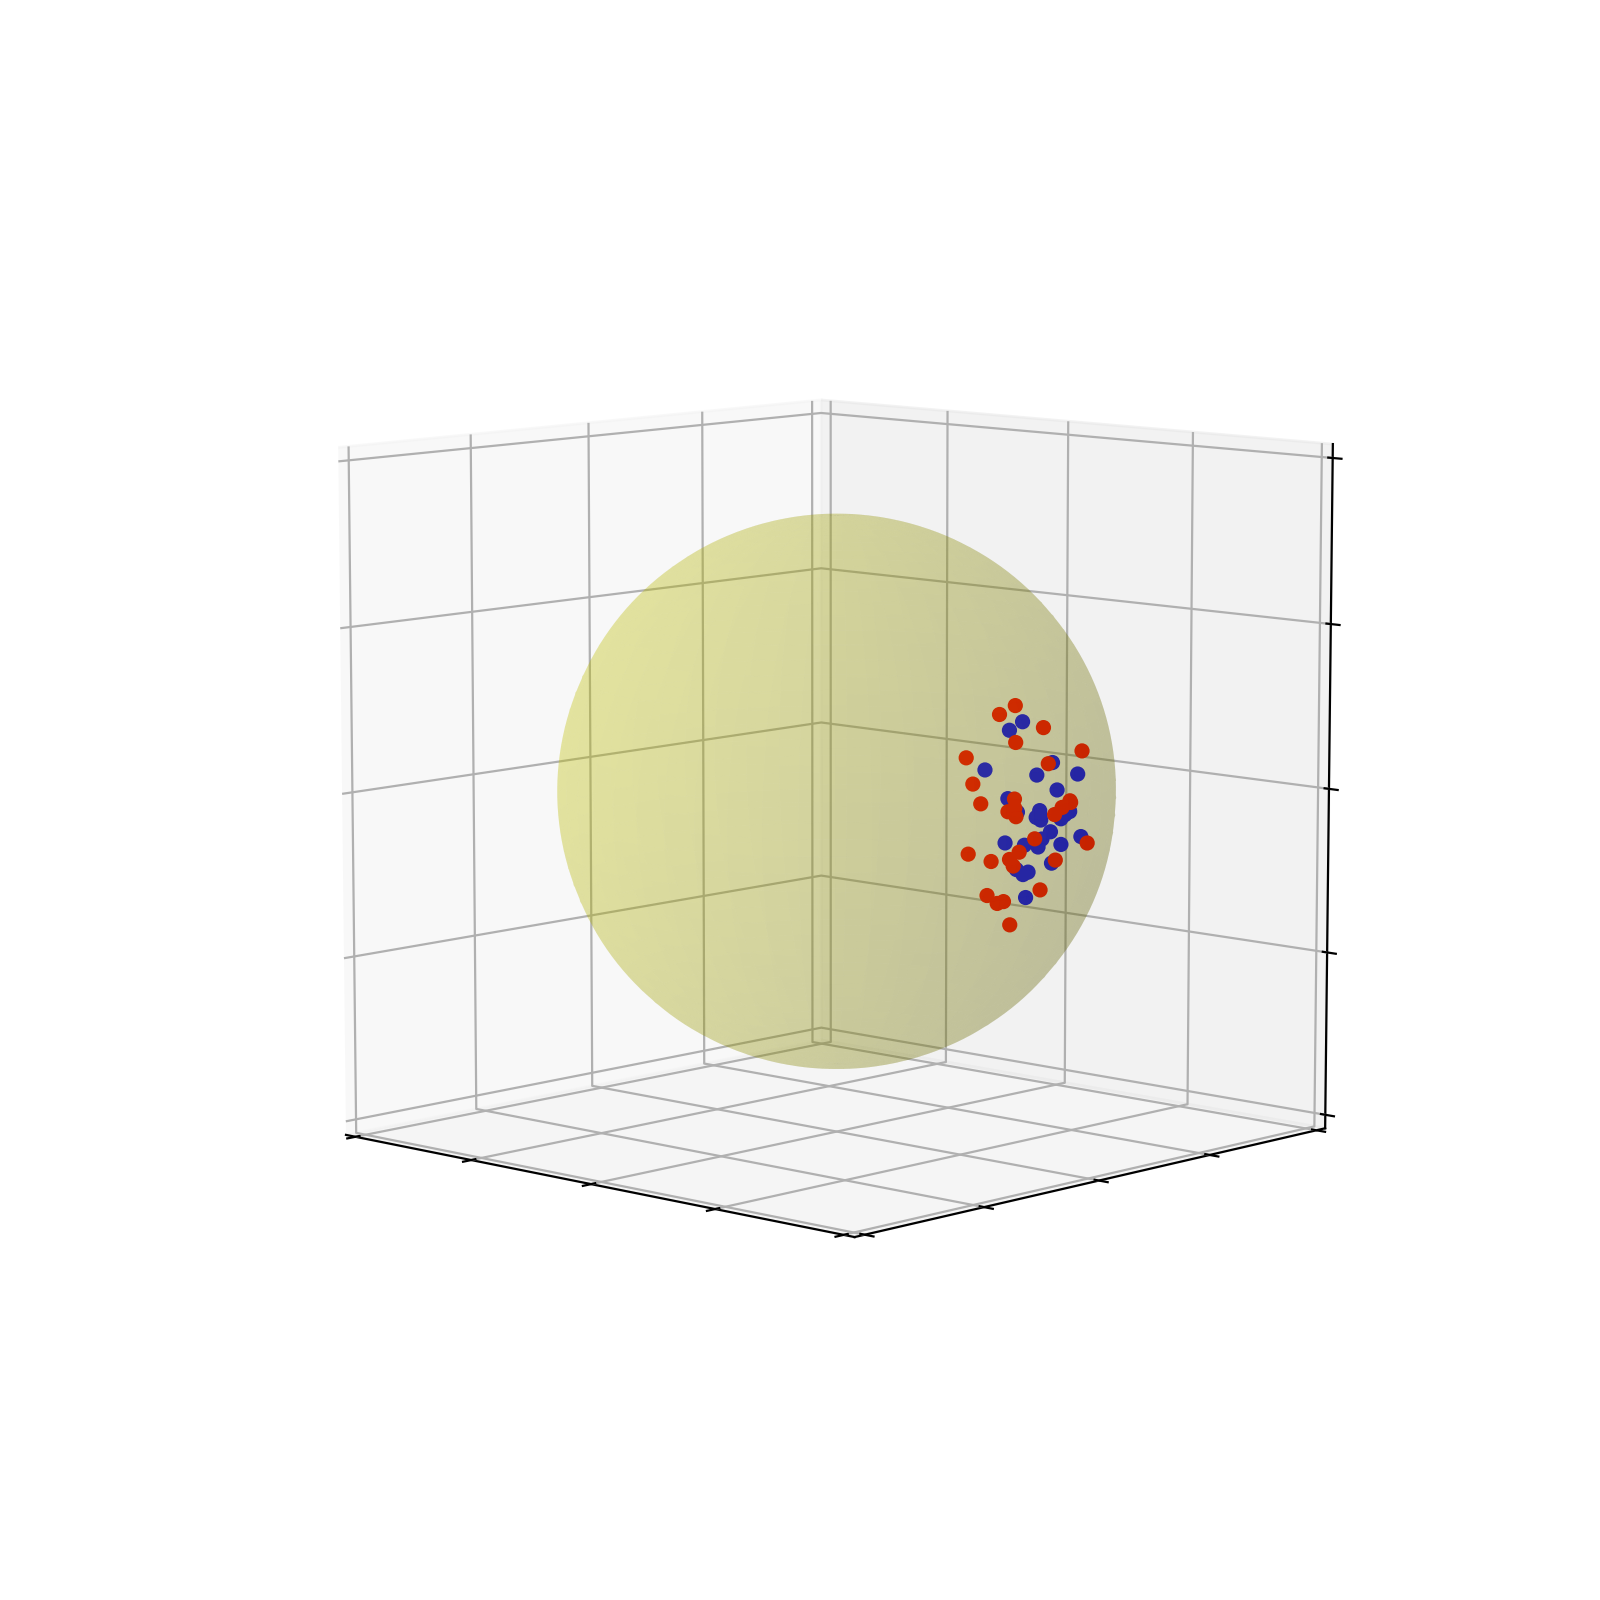

In [34]:
np.random.seed(42)
center = np.array([0, 0, 0])
radius = 1
viewpoint = np.array([1.1, 0, 0])
disk_points, sphere_points, frame = make_visible_points(center, radius, viewpoint, 30)
draw_visible_points(disk_points, sphere_points, frame, center, radius, viewpoint, viewpoint_alpha=0)

<IPython.core.display.Javascript object>


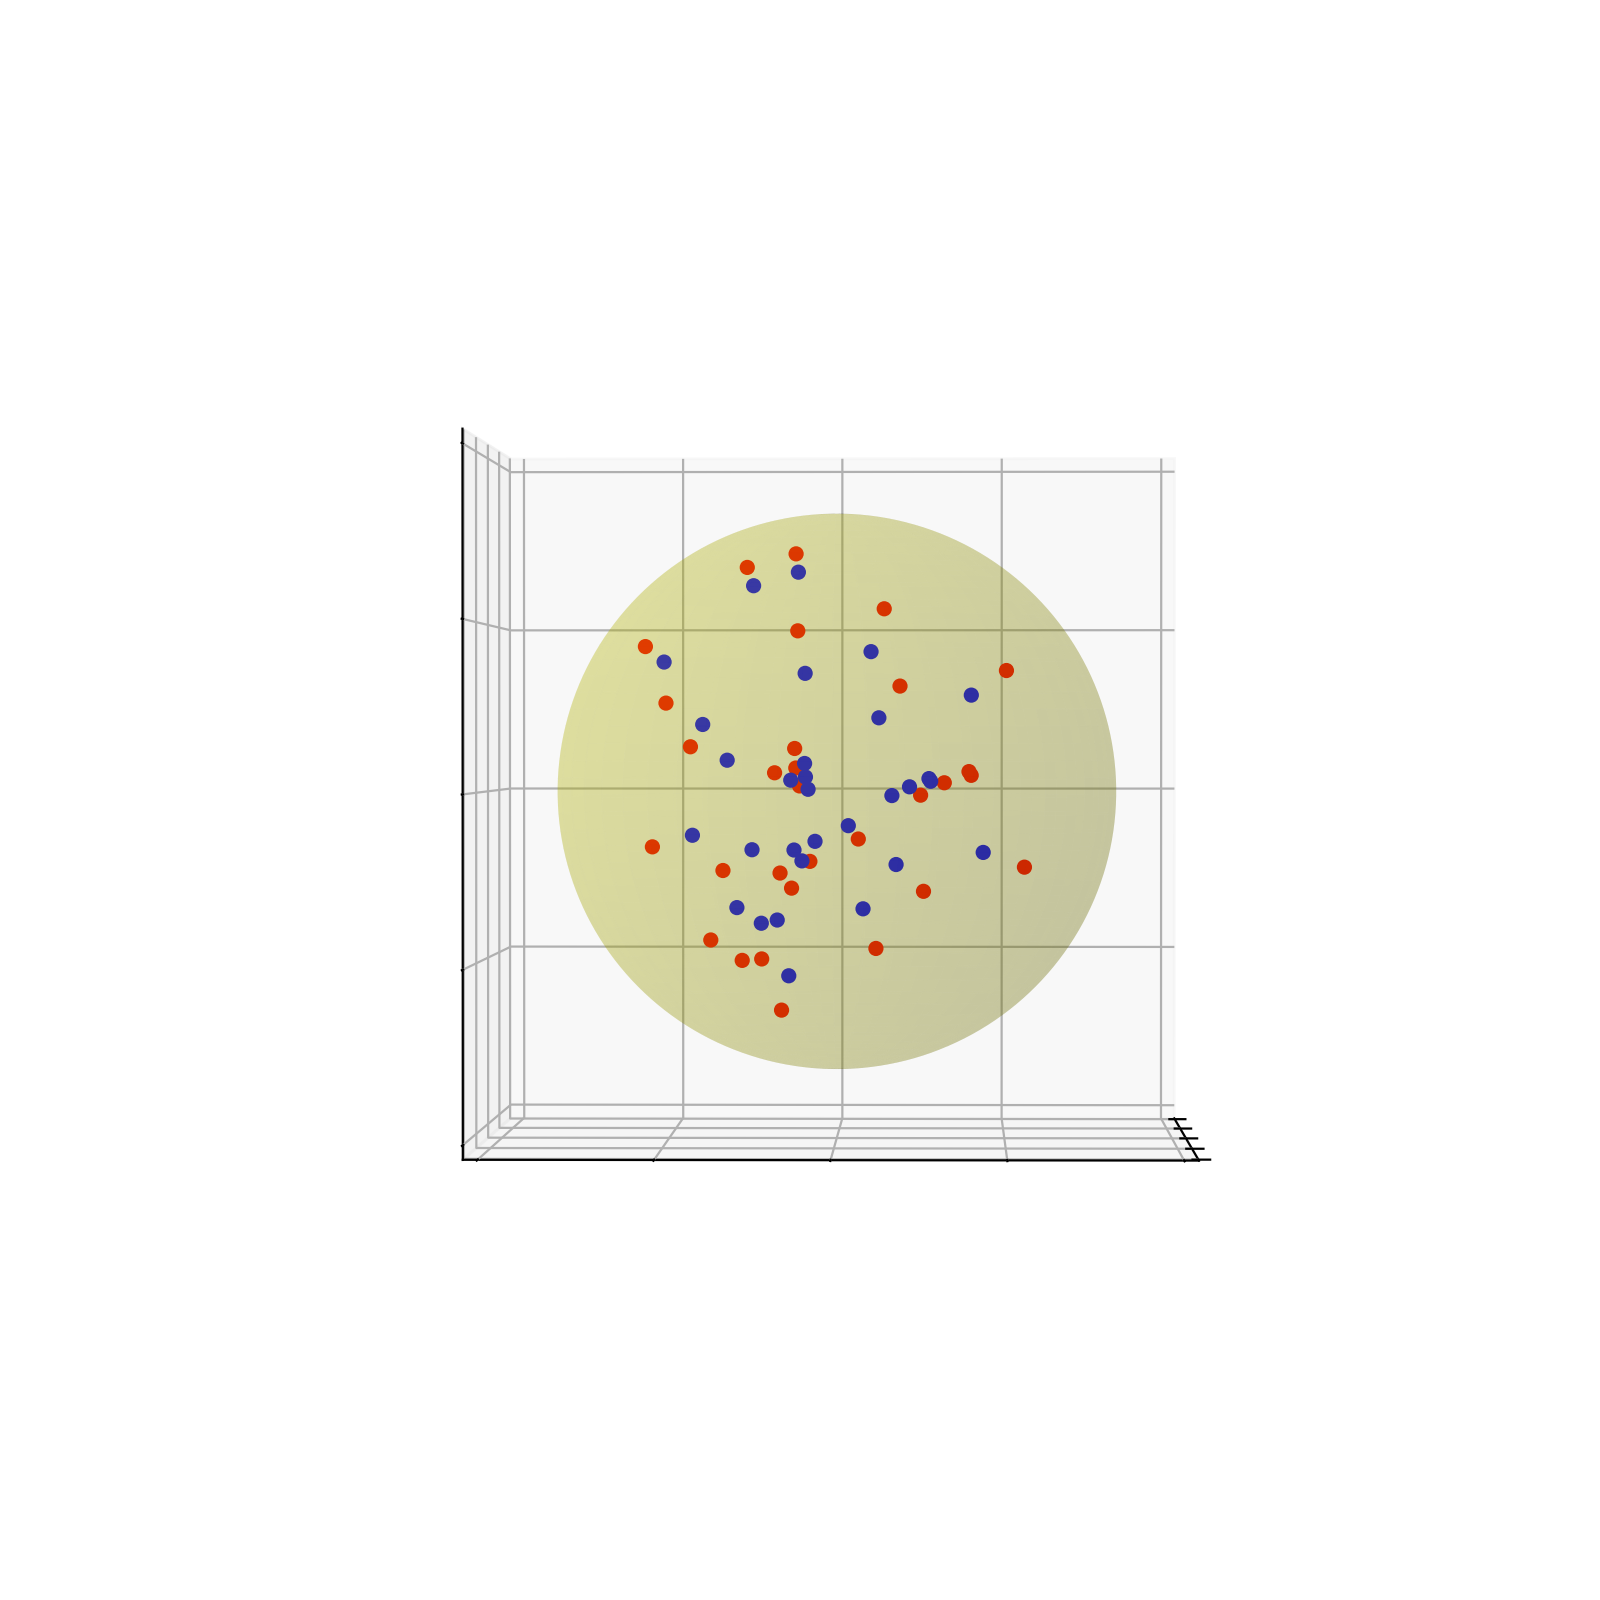

In [35]:
np.random.seed(42)
center = np.array([0, 0, 0])
radius = 1
viewpoint = np.array([2, 0, 0])
disk_points, sphere_points, frame = make_visible_points(center, radius, viewpoint, 30)
draw_visible_points(disk_points, sphere_points, frame, center, radius, viewpoint, viewpoint_alpha=0)

<IPython.core.display.Javascript object>


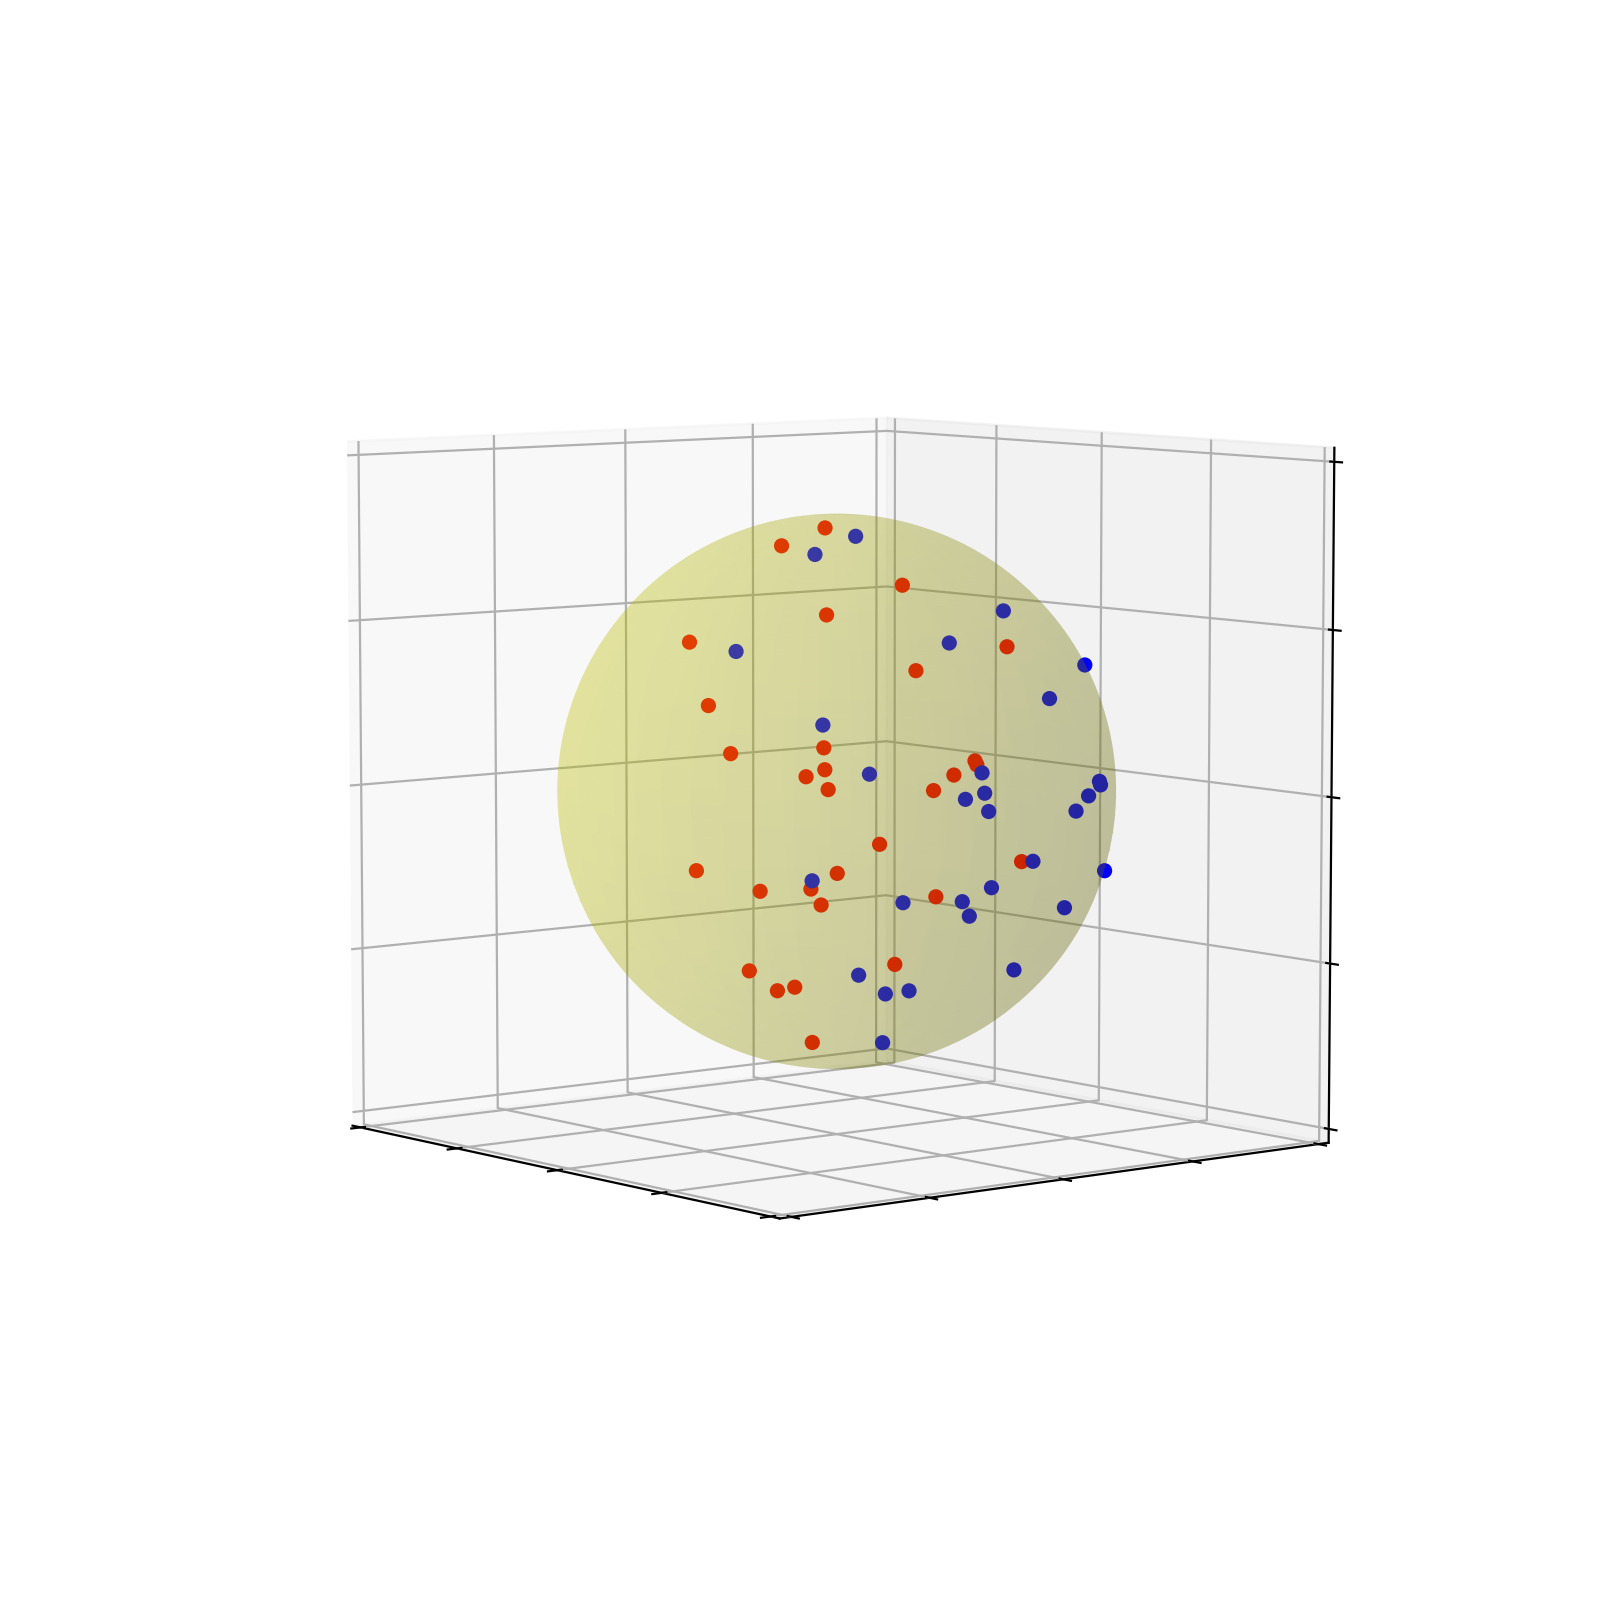

In [36]:
np.random.seed(42)
center = np.array([0, 0, 0])
radius = 1
viewpoint = np.array([8, 0, 0])
disk_points, sphere_points, frame = make_visible_points(center, radius, viewpoint, 30)
draw_visible_points(disk_points, sphere_points, frame, center, radius, viewpoint, viewpoint_alpha=0)